In [69]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Credit Card Fraud Detection: ULB Dataset

## Inspecting the Dataset

In [2]:
df = pd.read_csv('ecommerce.csv')
print(df.shape)
print(df.isnull().sum())
print(df.head())

(541909, 7)
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode  Quantity       InvoiceDate  UnitPrice  CustomerID  \
0    536365    85123A         6  12/01/2010 08:26       2.55     17850.0   
1    536365     71053         6  12/01/2010 08:26       3.39     17850.0   
2    536365    84406B         8  12/01/2010 08:26       2.75     17850.0   
3    536365    84029G         6  12/01/2010 08:26       3.39     17850.0   
4    536365    84029E         6  12/01/2010 08:26       3.39     17850.0   

          Country  
0  United Kingdom  
1  United Kingdom  
2  United Kingdom  
3  United Kingdom  
4  United Kingdom  
(354345, 7)


## Data Preprocessing

In [ ]:
df = df[df['Country'].isin(['United Kingdom'])]
df = df[df['Quantity'] > 0]
df = df.dropna()
print(df.shape)

## RFM Analysis

### Evaluating Monetary

In [10]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['M_Quartile'] = pd.qcut(df['TotalPrice'], q = 4, labels = range(1,5))

[4, 3, 2, 1]
[1, 2, 3, 4]


### Evaluating Recency

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df['DateDifference'] = (df['InvoiceDate'].max() - df['InvoiceDate']).dt.days
df['R_Quartile'] = pd.qcut(df['DateDifference'], q = 4, labels = range(4, 0, -1))

### Evaluating GroupBy CustomerID Values

In [42]:
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1) #NOTE: Snapshot date is the day after the final (max) date within the dataset.

rfm_df = df.groupby(['CustomerID']).agg({'InvoiceNo' : 'count',
                                         'TotalPrice' : 'sum',
                                         'InvoiceDate': lambda x: (snapshot_date - x.max()).days})

rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'MonetaryValue'}, inplace = True)

rfm_df.index = rfm_df.index.astype(int)

print(rfm_df.head())

            Frequency  MonetaryValue  Recency
CustomerID                                   
12346               1       77183.60      326
12747             103        4196.01        2
12748            4596       33719.73        1
12749             199        4090.88        4
12820              59         942.34        3


### Evaluating RFM Values

In [81]:
rfm_df['R_Quartile'] = pd.qcut(rfm_df['Recency'], q = 4, labels = range(4, 0, -1))
rfm_df['F_Quartile'] = pd.qcut(rfm_df['Frequency'], q = 4, labels = range(1, 5))
rfm_df['M_Quartile'] = pd.qcut(rfm_df['MonetaryValue'], q = 4, labels = range(1, 5))
rfm_df['RFM_Value'] = rfm_df[['R_Quartile', 'F_Quartile', 'M_Quartile']].sum(axis=1)
rfm_df['RFM_Str'] = rfm_df['R_Quartile'].astype(str) + rfm_df['F_Quartile'].astype(str) + rfm_df['M_Quartile'].astype(str)

print(rfm_df.head())

            Frequency  MonetaryValue  Recency R_Quartile F_Quartile  \
CustomerID                                                            
13256               1           0.00       14          4          1   
16738               1           3.75      298          1          1   
14792               2           6.20       64          2          1   
16454               2           6.90       45          3          1   
17956               1          12.75      249          1          1   

           M_Quartile  RFM_Value RFM_Str  Cluster  
CustomerID                                         
13256               1        6.0     411        0  
16738               1        3.0     111        2  
14792               1        4.0     211        2  
16454               1        5.0     311        0  
17956               1        3.0     111        2  


## Exploratory Data Analysis

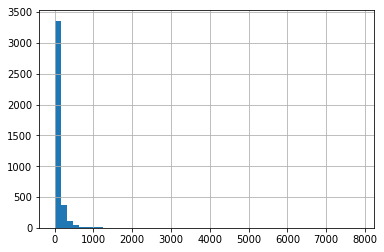

In [117]:
rfm_df['Frequency'].hist(bins=50)
plt.show()

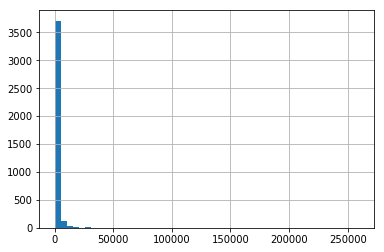

In [122]:
rfm_df['MonetaryValue'].hist(bins=50)
plt.show()

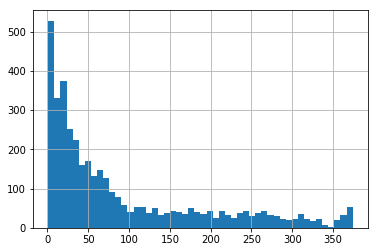

In [119]:
rfm_df['Recency'].hist(bins=50)
plt.show()

## Machine Learning Analysis: K-Means Clustering

### Evaluating the Correct Value for K

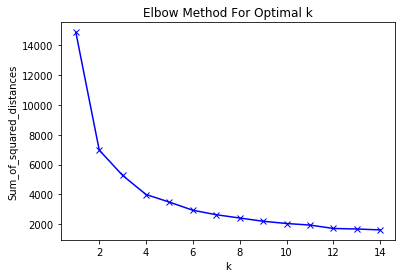

In [82]:
X = rfm_df[['R_Quartile', 'F_Quartile', 'M_Quartile']]


Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Square Distance')
plt.title('Elbow Method For Optimal k')
plt.show()

In [94]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['X', 'Y', 'Z'])

print(centers_df)

rfm_df['Cluster'] = y_kmeans


          X         Y         Z
0  3.385542  1.832664  1.805890
1  1.380723  1.448996  1.481124
2  3.596278  3.618932  3.584142
3  1.704185  3.012987  3.142857


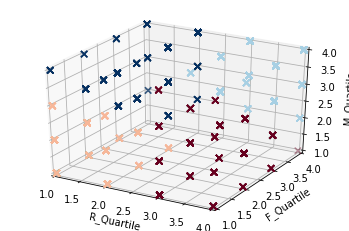

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfm_df['R_Quartile'])
y = np.array(rfm_df['F_Quartile'])
z = np.array(rfm_df['M_Quartile'])
ax.set_xlabel('R_Quartile')
ax.set_ylabel('F_Quartile')
ax.set_zlabel('M_Quartile')
ax.set_xlim(1, 4)
ax.set_ylim(1, 4)
ax.set_zlim(1, 4)

ax.scatter(x,y,z, marker="x", c=rfm_df['Cluster'], s=40, cmap="RdBu")

plt.show()

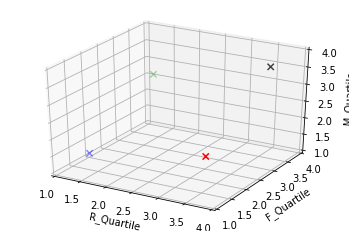

In [108]:
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(centers_df['R_Quartile'])
y = np.array(centers_df['F_Quartile'])
z = np.array(centers_df['M_Quartile'])
ax.set_xlabel('R_Quartile')
ax.set_ylabel('F_Quartile')
ax.set_zlabel('M_Quartile')
ax.set_xlim(1, 4)
ax.set_ylim(1, 4)
ax.set_zlim(1, 4)

ax.scatter(x, y, z, marker="x", s=40, c=['r', 'b', 'k', 'g'], cmap="RdBu")

plt.show()